In [1]:
import os
import re
import sys
import yaml
import multiprocessing
import itertools

import pypsa

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import matplotlib.colors as mcolors

sns.set_theme(style="whitegrid")

# Replace __file__ with the absolute path of the notebook file
notebook_path = "/home/koen/research/eu-hydrogen/notebooks/scratch.ipynb"

# Insert ../scripts/ to sys.path
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(notebook_path), '..', 'scripts')))

ERROR 1: PROJ: proj_create_from_database: Open of /fp/homes01/u01/ec-koenvg/.conda/envs/my_base/envs/eu-hydrogen/share/proj failed


In [2]:
config_fn = "../config/ccs-scenarios.yaml"
config = yaml.safe_load(open(config_fn))

config_default = yaml.safe_load(open("../config/config.default.yaml"))

results_dir = "../results"

use_cache = True

In [3]:
green = "#5fc983"
dark_green = "#4b7559"
max_c = "#c95f7e"
min_c = "#975fc9"

titlesize = 9
textsize = 8
labelsize = 7

# cm in inch
cm = 1 / 2.54

H2_MAX = 110

# targets = [(2040, 25), (2050, 25)]
targets = [(2040, 25)]

In [4]:
def lighten_color(hex_color, amount=0.5):
    # Convert hex color to RGB
    rgb_color = mcolors.hex2color(hex_color)
    # Define white color in RGB
    white = (1, 1, 1)
    # Blend the colors
    blended_color = tuple(max((1 - amount) * x + amount * y, 0) for x, y in zip(rgb_color, white))
    # Convert RGB to hex
    return mcolors.to_hex(blended_color)

In [5]:
stat_names = [
    "h2prod",
    "imports",
    "system_cost",
    "obj_bound_dual",
    "h2price",
    "co2seq",
    "dac",
    "elec_cap",
    "elec_cf",
    "total_onwind",
    "total_offwind",
    "total_solar",
]


def stats(n: pypsa.Network):
    # H2
    i = n.links.loc[n.links.carrier.isin(["H2 Electrolysis"])].index
    MWh_h2 = -(
        n.links_t.p1.loc[:, i].sum(axis=1) * n.snapshot_weightings.generators
    ).sum()
    h2prod = (MWh_h2 / 33.33) / 1e6

    # Imports
    i = n.generators.loc[n.generators.index.str.contains("green import")].index
    imports = (
        n.generators_t.p.loc[:, i].sum(axis=1) * n.snapshot_weightings.generators
    ).sum() / 1e6

    # System cost
    system_cost = n.statistics.capex().sum() + n.statistics.opex().sum()

    # System cost bound dual
    obj_bound_dual = (
        n.global_constraints.at["total_system_cost", "mu"]
        if "total_system_cost" in n.global_constraints.index
        else np.nan
    )

    # H2 price
    h2_buses = n.buses.index[n.buses.carrier == "H2"]
    h2price = (n.buses_t.marginal_price[h2_buses].mean(axis=1) * n.snapshot_weightings.generators).sum() / 8760

    # Total CO2 sequestration
    co2seq = n.stores.loc[n.stores.carrier == "co2 sequestered", "e_nom_opt"].sum()

    # Total amount of CO2 captured by DAC
    dac_i = n.links.loc[n.links.carrier == "DAC"].index
    dac = (
        n.links_t.p0.loc[:, dac_i].sum(axis=1) * n.snapshot_weightings.generators
    ).sum()

    # Total installed capacity of electrolysers
    elec_i = n.links.loc[n.links.carrier == "H2 Electrolysis"].index
    elec_cap = n.links.loc[elec_i, "p_nom_opt"].sum()

    # Mean capacity factor of electrolysers
    if elec_cap > 0:
        elec_cf = (
            n.links_t.p0.loc[:, elec_i].sum(axis=1) * n.snapshot_weightings.generators
        ).sum() / (elec_cap * n.snapshot_weightings.generators.sum())
    else:
        elec_cf = np.nan

    # Total installed onshore wind
    total_onwind = n.generators.loc[n.generators.carrier == "onwind", "p_nom_opt"].sum()

    # Total installed offshore wind
    total_offwind = n.generators.loc[
        n.generators.carrier.isin(["offwind-ac", "offwind-dc", "offwind-float"]),
        "p_nom_opt",
    ].sum()

    # Total installed solar
    total_solar = n.generators.loc[n.generators.carrier == "solar", "p_nom_opt"].sum()

    return {
        "h2prod": h2prod,
        "imports": imports,
        "system_cost": system_cost,
        "obj_bound_dual": obj_bound_dual,
        "h2price": h2price,
        "co2seq": co2seq,
        "dac": dac,
        "elec_cap": elec_cap,
        "elec_cf": elec_cf,
        "total_onwind": total_onwind,
        "total_offwind": total_offwind,
        "total_solar": total_solar,
    }

In [6]:
if not use_cache:
    nets = {}

    scenario_list = [config["run"]["name"]]

    # Assume that the following are uniquely defined for each run:
    ll = config["scenario"]["ll"][0]
    clusters = config["scenario"]["clusters"][0]
    opts = config["scenario"]["opts"][0]

    # The following are taken to vary for each run.
    sector_opts = config["scenario"]["sector_opts"]
    planning_horizons = config["scenario"]["planning_horizons"]
    slacks = config["scenario"]["slack"]
    senses = ["min", "max"]

    resolution = None

    # If resolution not none, replace all instances of "\d+seg" with resolution in sector_opts
    if resolution is not None:
        sector_opts = [re.sub(r"\d+seg", resolution, s) for s in sector_opts]


    def load_stats(file):
        return stats(pypsa.Network(file)) if os.path.exists(file) else {v: np.nan for v in stat_names}


    index = list(itertools.product(scenario_list, sector_opts, planning_horizons, slacks, senses))
    index_opt = list(itertools.product(scenario_list, sector_opts, planning_horizons, [0], ["opt"]))

    with multiprocessing.Pool(30) as pool:
        networks = pool.map(
            load_stats,
            [
                f"{results_dir}/{s}/postnetworks/base_s_{clusters}_l{ll}_{opts}_{o}_{h}_{sense}{slack}.nc"
                for s, o, h, slack, sense in index
            ],
        )

        networks.extend(
            pool.map(
                load_stats,
                [
                    f"{results_dir}/{s}/postnetworks/base_s_{clusters}_l{ll}_{opts}_{o}_{h}.nc"
                    for s, o, h, _, _ in index_opt
                ],
            )
        )

    networks = dict(zip(index + index_opt, networks))

In [7]:
if not use_cache:
    df = pd.DataFrame(networks).T.reset_index()
    df.columns = ["scenario", "opts", "horizon", "slack", "sense"] + stat_names

    # Drop the "scenario" column
    df.drop(columns=["scenario"], inplace=True)

    # Strip any suffix of the form "-\d+seg" from the "opts" column
    df["opts"] = df["opts"].str.replace(r"-\d+seg", "", regex=True)

    # The "opts" column has the form "XX-YY-ZZ-..."; we want to split this into separate columns and keep only the last character
    flags = list(map(lambda s: s[:-1], df.at[0, "opts"].split("-")))
    df[flags] = df["opts"].str.split("-", expand=True).map(lambda s: s[-1])
    df.drop(columns=["opts"], inplace=True)

    # Add a column concatenating the year and flags
    df["scenario"] = df[flags].apply(lambda x: "".join(x), axis=1)

    # Now set the index to the scenario, year, flags, slack and horizon
    df.set_index(["scenario"] + flags + ["sense", "slack", "horizon"], inplace=True)

    df.to_csv("cache_ccs_scenarios.csv")

    display(df)
else:
    fn = "cache_ccs_scenarios.csv"
    cols = pd.read_csv(fn).columns
    df = pd.read_csv(fn, index_col=list(range(len(cols) - len(stat_names))))

    display(df)

h2prod       imports  \
scenario SEQ SEQCOST CCCOST sense slack horizon                               
aaa      a   a       a      min   0.02  2025    -0.000000e+00  1.856239e-11   
                            max   0.02  2025     3.848431e+00  3.729650e-07   
                            min   0.05  2025    -0.000000e+00  2.879886e-11   
                            max   0.05  2025     9.206266e+00  1.274203e-06   
                            min   0.10  2025    -0.000000e+00  1.038858e-11   
...                                                       ...           ...   
ccc      c   c       c      opt   0.00  2030     9.321494e-08  3.106477e-06   
                                        2035     1.063297e+00  3.543969e+01   
                                        2040     9.827924e+00  3.022921e+02   
                                        2045     7.442934e+00  2.072187e+02   
                                        2050     6.699210e+00  2.232847e+02   

                                                  system_cost  obj_bound_dual  \
scenario SEQ SEQCOST CCCOST sense slack horizon                                 
aaa      a   a       a      min   0.02  2025     9.850118e+11             NaN   
                            max   0.02  2025     9.997869e+11      -14.410910   
                            min   0.05  2025     9.850118e+11             NaN   
                            max   0.05  2025     1.021950e+12      -12.918233   
                            min   0.10  2025     9.850118e+11             NaN   
...                                                       ...             ...   
ccc      c   c       c      opt   0.00  2030     9.371180e+11             NaN   
                                        2035     8.510890e+11             NaN   
                                        2040     9.256098e+11             NaN   
                                        2045     8.416537e+11             NaN   
                                        2050     7.791140e+11             NaN   

                                                   h2price        co2seq  \
scenario SEQ SEQCOST CCCOST sense slack horizon                            
aaa      a   a       a      min   0.02  2025     59.881565  0.000000e+00   
                            max   0.02  2025      0.851263 -1.661415e+01   
                            min   0.05  2025     59.879811  0.000000e+00   
                            max   0.05  2025      0.639892 -1.022408e+02   
                            min   0.10  2025     59.870527  0.000000e+00   
...                                                    ...           ...   
ccc      c   c       c      opt   0.00  2030     71.609341  1.000000e+08   
                                        2035     91.765983  3.000000e+08   
                                        2040     98.480856  5.000000e+08   
                                        2045     65.197700  6.804824e+08   
                                        2050     64.599053  7.463153e+08   

                                                          dac      elec_cap  \
scenario SEQ SEQCOST CCCOST sense slack horizon                               
aaa      a   a       a      min   0.02  2025     3.426333e-01      0.000000   
                            max   0.02  2025     3.190102e-01  24935.215468   
                            min   0.05  2025     3.079901e-01      0.000000   
                            max   0.05  2025     1.915513e+00  59642.121767   
                            min   0.10  2025     1.697456e-01      0.000000   
...                                                       ...           ...   
ccc      c   c       c      opt   0.00  2030     4.298558e-01      0.001014   
                                        2035     5.352974e-01  10030.541175   
                                        2040     7.060515e+07  96909.131923   
                                        2045     1.186893e+08  96909.125845   
                                    

# Plots

/tmp/ipykernel_177280/2708111225.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


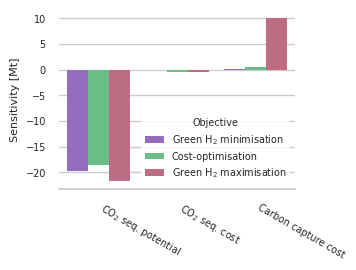

sense,a,b,min,opt,max
variable,,,,,
CO$_2$ seq. potential,275,\ $\rightarrow$ 1100 Mt/a,-19.7,-18.5,-21.6
Carbon capture cost,$+50\%$,\ $\rightarrow$ $-10\%$,0.2,0.4,10.1
CO$_2$ seq. cost,30,\ $\rightarrow$ 15 EUR/t,-0.1,-0.5,-0.5


In [8]:
# Global sensitivity analysis

horizon = 2050
cols = ["SEQ", "SEQCOST", "CCCOST"]
pretty_names = {
    "SEQ": "CO$_2$ seq. potential",
    "SEQCOST": "CO$_2$ seq. cost",
    "CCCOST": "Carbon capture cost",
}
scenario_changes = {
    "SEQ": ["275", "\\ $\\rightarrow$ 1100 Mt/a"],
    "SEQCOST": ["30", "\\ $\\rightarrow$ 15 EUR/t"],
    "CCCOST": ["$+50\\%$", "\\ $\\rightarrow$ $-10\\%$"],
}

results = pd.DataFrame(index=cols)

for sense in ["min", "opt", "max"]:

    selection = df.xs(sense, level="sense").xs(horizon, level="horizon").copy()
    selection.reset_index(inplace=True)

    # Drop rows where h2prod is NaN
    selection = selection.dropna(subset=["h2prod"])

    # Multivariable linear regression of h2prod with chosen columns
    for col in cols:
        selection[col] = selection[col].map({"a": 0, "b": 0.5, "c": 1})

    X = selection[cols]
    X = X.astype(float)

    X = sm.add_constant(X)
    y = selection["h2prod"]

    model = sm.OLS(y, X).fit()

    results[sense] = model.params[1:]


# Barplot of coefficients
fig, ax = plt.subplots(figsize=(8 * cm, 7 * cm))

# Make wide-form
results = results.T.reset_index().melt(
    id_vars="index", var_name="variable", value_name="coefficient"
)
results.rename(columns={"index": "sense"}, inplace=True)

palette = {"min": min_c, "opt": green, "max": max_c}
sns.barplot(
    data=results,
    ax=ax,
    x="variable",
    y="coefficient",
    hue="sense",
    palette=palette,
    edgecolor="none",
)

# Set labels
ax.set_ylabel("Sensitivity [Mt]", fontsize=textsize)
ax.set_xlabel(None)

# Rename x-ticks
ax.set_xticklabels(
    [pretty_names[t.get_text()] for t in ax.get_xticklabels()], rotation=-30, ha="left"
)

# Tick fontsize
ax.tick_params(axis="both", which="major", labelsize=labelsize)

# Format legend entries "min" -> "Minimisation", etc.
patches, labels = ax.get_legend_handles_labels()
l = ax.legend(
    patches,
    ["Green H$_2$ minimisation", "Cost-optimisation", "Green H$_2$ maximisation"],
    title="Objective",
    title_fontsize=labelsize,
    fontsize=labelsize,
)
l.get_frame().set_linewidth(0.0)

# Turn off spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

fig.subplots_adjust(bottom=0.3, left=0.15, top=0.95)

plt.show()

# Pivot to make values of "sense" column to columns, "coefficients" as values
results = results.pivot(index="variable", columns="sense", values="coefficient")
# Add scenario changes as two columns
results["a"] = [scenario_changes[col][0] for col in results.index]
results["b"] = [scenario_changes[col][1] for col in results.index]
# Use pretty names
results.index = results.index.map(pretty_names)
# Sort rows by decrease absolute value of opt
results = results.sort_values("max", key=abs, ascending=False)
# Round to 1 decimal
results = results.round(1)
# Order columns from min to max
results = results[["a", "b", "min", "opt", "max"]]
display(results)
results.to_csv("figures/ccs-sensitivity.csv")